# Final Model Training, Evaluation, and Deployment

This notebook represents the final phase of the classification project. It takes the best components identified in previous stages (preprocessing, feature selection, hyperparameters) to train a final production-ready model. The process includes a comprehensive evaluation on the test set, diagnostic analysis to understand model behavior, and the saving of all necessary artifacts for deployment and reproducibility.

# Setup and Initialization

This section handles the initial setup, imports, and loading of artifacts from previous phases.

## Optional: Google Colab Setup

Uncomment and run this cell if working in Google Colab environment.

In [1]:
# Run on Google Colab (optional)
#from google.colab import drive
#drive.mount('/drive', force_remount=True)

## Import Libraries

Import all necessary libraries for advanced tuning, model interpretation, and final training.

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from typing import Dict, Any, List, Tuple, Optional
import pickle
import collections

# Core ML libraries
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import (
    TimeSeriesSplit,
    learning_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve, matthews_corrcoef,
    classification_report, log_loss
)

# Model interpretation libraries
import shap
from sklearn.inspection import permutation_importance

# Imbalanced learning and ensemble libraries
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import (
    EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier
)

# Custom utilities from the project
from Utilities.custom_transformers import STKDEAndRiskLabelTransformer, SlidingWindowSplit, CyclicalTransformer

# Models
from xgboost import XGBClassifier

# Set random seeds and display settings for reproducibility and clarity
np.random.seed(42)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully.")

All libraries imported successfully.


## Define Paths and Directories

Set up directory structure for loading previous results and saving final outputs.

In [3]:
# Define base directories
base_dir = r"C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs"
preprocessing_dir = os.path.join(base_dir, "Classification (Preprocessing)")
modeling_dir = os.path.join(base_dir, "Classification (Modeling)")
tuning_dir = os.path.join(base_dir, "Classification (Tuning)")
final_dir = os.path.join(base_dir, "Classification (Final)")

# Create the directory for final results if it doesn't exist
os.makedirs(final_dir, exist_ok=True)

print(f"Directory Structure:")
print(f"   Preprocessing artifacts: {preprocessing_dir}")
print(f"   Modeling results: {modeling_dir}")
print(f"   Tuning results: {tuning_dir}")
print(f"   Final outputs: {final_dir}")

# Verify that all required input directories exist
required_dirs = [preprocessing_dir, modeling_dir, tuning_dir]
missing_dirs = [d for d in required_dirs if not os.path.exists(d)]

if missing_dirs:
    raise FileNotFoundError(f"Required directories not found: {missing_dirs}. Please run previous notebooks.")
else:
    print("\nAll required directories found.")

Directory Structure:
   Preprocessing artifacts: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Preprocessing)
   Modeling results: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)
   Tuning results: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)
   Final outputs: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)

All required directories found.


## Load Previous Phase Artifacts

Load data, models, and results from previous phases to continue with advanced tuning.

In [4]:
def load_final_phase_artifacts(preprocessing_dir: str, tuning_dir: str, best_model_name: str) -> Dict[str, Any]:
    """Load final phase artifacts with comprehensive error handling."""
    print("=== Loading Final Phase Artifacts ===")
    if not os.path.exists(tuning_dir):
        raise FileNotFoundError(f"Tuning results directory not found: {tuning_dir}")

    artifacts = {}
    paths = {
        'pipeline': os.path.join(tuning_dir, f"{best_model_name}_final_pipeline.joblib"),
        'best_params': os.path.join(tuning_dir, f"{best_model_name}_best_params.json"),
        'optimal_threshold': os.path.join(tuning_dir, f"{best_model_name}_optimal_threshold.json"),
        'X_train': os.path.join(tuning_dir, "X_train.pkl"),
        'X_test': os.path.join(tuning_dir, "X_test.pkl"),
        'stkde_params': os.path.join(preprocessing_dir, "stkde_optimal_params.json")
    }

    # Load pipeline components
    try:
        pipeline_components = joblib.load(paths['pipeline'])
        artifacts['preprocessor'] = pipeline_components.get('preprocessor')
        artifacts['feature_selector'] = pipeline_components.get('feature_selector')
        print(f"Loaded pipeline components from: {paths['pipeline']}")
    except Exception as e:
        raise IOError(f"Failed to load pipeline components from {paths['pipeline']}: {e}")

    # Load other JSON and Pickle files
    for key, path in paths.items():
        if key == 'pipeline': continue
        try:
            if path.endswith('.json'):
                with open(path, "r") as f:
                    data = json.load(f)
                    if key == 'optimal_threshold':
                        artifacts[key] = data.get('optimal_threshold')
                    else:
                        artifacts[key] = data
            elif path.endswith('.pkl'):
                artifacts[key] = pd.read_pickle(path)
            print(f"Loaded {key} from: {path}")
        except Exception as e:
            raise IOError(f"Failed to load {key} from {path}: {e}")
            
    artifacts['feature_names'] = list(artifacts['X_train'].columns)
    return artifacts

try:
    # Programmatically load the best model's name from the tuning phase
    best_model_info_path = os.path.join(tuning_dir, "best_model_info.json")
    with open(best_model_info_path, "r") as f:
        best_model_info = json.load(f)
        best_model_name = best_model_info.get("best_model_name")
    print(f"Identified best model from tuning phase: {best_model_name}\n")

    artifacts = load_final_phase_artifacts(preprocessing_dir, tuning_dir, best_model_name)
    X_train = artifacts['X_train']
    X_test = artifacts['X_test']
    feature_names = artifacts['feature_names']
    preprocessor = artifacts['preprocessor']
    feature_selector = artifacts['feature_selector']
    best_params = artifacts['best_params']
    optimal_threshold = artifacts['optimal_threshold']
    stkde_params = artifacts['stkde_params']

    print(f"\nSuccessfully loaded all artifacts.")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"Optimal threshold: {optimal_threshold}")

except Exception as e:
    print(f"An error occurred during artifact loading: {e}")
    raise

Identified best model from tuning phase: LogisticRegression

=== Loading Final Phase Artifacts ===
Loaded pipeline components from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_final_pipeline.joblib
Loaded best_params from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_best_params.json
Loaded optimal_threshold from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_optimal_threshold.json
Loaded X_train from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\X_train.pkl
Loaded X_test from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\X_test.pkl
Loaded stkde_params from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Preprocessing)\stkde_optimal_params.json

Successfully loaded all artifacts.
X_train shape: (57

## Final y_train and y_test Calculation
Calculate the final labels for training and testing datasets based on the best model's predictions.

In [5]:
print("=== Final Target Engineering (Using Sliding Window Logic) ===")

# Load the window size determined during the modeling phase
window_config_path = os.path.join(modeling_dir, 'window_config.json')
if not os.path.exists(window_config_path):
    raise FileNotFoundError(f"Window configuration file not found at {window_config_path}. Please re-run Modeling.ipynb.")

with open(window_config_path, 'r') as f:
    window_config = json.load(f)
    train_window_size = window_config.get('train_window_size')
    print(f"Loaded training window size: {train_window_size}")

# --- SLIDING WINDOW LOGIC APPLIED HERE (DATA LEAKAGE PREVENTION) ---
# 1. Select only the most recent data for the final training set.
print(f"\nSelecting the last {train_window_size} samples from sorted training data for final training.")
X_train_final_window = X_train.sort_values(by=['YEAR', 'MONTH', 'DAY', 'HOUR']).tail(train_window_size)

# 2. Initialize the STKDE transformer with optimal parameters.
hs_optimal = stkde_params.get('hs_opt')
ht_optimal = stkde_params.get('ht_opt')
stkde_transformer = STKDEAndRiskLabelTransformer(
    hs=hs_optimal, ht=ht_optimal, threshold_strategy='dynamic_jenks', n_classes=2
)
print(f"Initialized STKDEAndRiskLabelTransformer with hs={hs_optimal}, ht={ht_optimal}")

# 3. Fit the transformer ONLY on the final training window and transform it to get final training labels.
# This is a critical step to prevent data leakage. The risk threshold is determined solely from this recent data window.
print("\nFitting transformer on the final training window to determine final risk threshold...")
dummy_y_train = pd.Series(0, index=X_train_final_window.index) # Dummy y is required by fit_transform signature
_, y_train_engineered = stkde_transformer.fit_transform(X_train_final_window, dummy_y_train)

print("Final threshold determined and y_train_engineered created.")
print(f"  Shape of y_train_engineered: {y_train_engineered.shape}")
print(f"  Class distribution in final y_train_engineered:\n{y_train_engineered.value_counts(normalize=True).to_string()}")

# 4. Use the FITTED transformer to transform the test data.
# The transformer now applies the threshold learned from the training window to the test set.
print("\nTransforming the test set using the window-fitted transformer...")
dummy_y_test = pd.Series(0, index=X_test.index)
_, y_test_engineered = stkde_transformer.transform(X_test, dummy_y_test)

print("y_test_engineered created.")
print(f"  Shape of y_test_engineered: {y_test_engineered.shape}")
print(f"  Class distribution in final y_test_engineered:\n{y_test_engineered.value_counts(normalize=True).to_string()}")

# IMPORTANT: Overwrite X_train to be used in subsequent cells for model fitting.
X_train = X_train_final_window
print(f"\nUpdated X_train to be the final window of shape: {X_train.shape}")

=== Final Target Engineering (Using Sliding Window Logic) ===
Loaded training window size: 162878

Selecting the last 162878 samples from sorted training data for final training.
Initialized STKDEAndRiskLabelTransformer with hs=250, ht=75

Fitting transformer on the final training window to determine final risk threshold...
Final threshold determined and y_train_engineered created.
  Shape of y_train_engineered: (162878,)
  Class distribution in final y_train_engineered:
RISK_LEVEL_engineered
0    0.656903
1    0.343097

Transforming the test set using the window-fitted transformer...
y_test_engineered created.
  Shape of y_test_engineered: (144344,)
  Class distribution in final y_test_engineered:
RISK_LEVEL_engineered
0    0.973764
1    0.026236

Updated X_train to be the final window of shape: (162878, 33)


# 3. Production Model Training and Evaluation

**Goal:** Train the final production model and comprehensively evaluate its performance on the unseen test set.

**Steps:**
1.  **Pipeline Assembly and Training:** The full production pipeline is assembled, combining the preprocessor, feature selector, and the classifier with its optimal hyperparameters. The pipeline is then trained (`.fit()`) using the final training data (`X_train_final_window` and `y_train_engineered`).
2.  **Test Set Evaluation:** The trained model predicts probabilities on `X_test`. These are converted to binary classes using the pre-determined `optimal_threshold`. A comprehensive evaluation report is generated, including key metrics and visualizations.

=== Production Model Training and Evaluation ===
Assembling the production pipeline...
Final classifier parameters: {'random_state': 42, 'max_iter': 1000, 'class_weight': 'balanced', 'n_jobs': -1, 'solver': 'liblinear', 'penalty': 'l2', 'C': 100.0}
Training the final model on 162878 samples...


C:\Users\ferdi\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Training completed in 55.35 seconds.

Evaluating the model on the test set...
Evaluation Metrics:
  f1_score: 0.3693
  precision: 0.3499
  recall: 0.3911
  accuracy: 0.9650
  roc_auc: 0.9047
  mcc: 0.3519
  log_loss: 0.2383
  optimal_threshold: 0.6400
  training_duration_seconds: 55.3514

Generating evaluation dashboard...


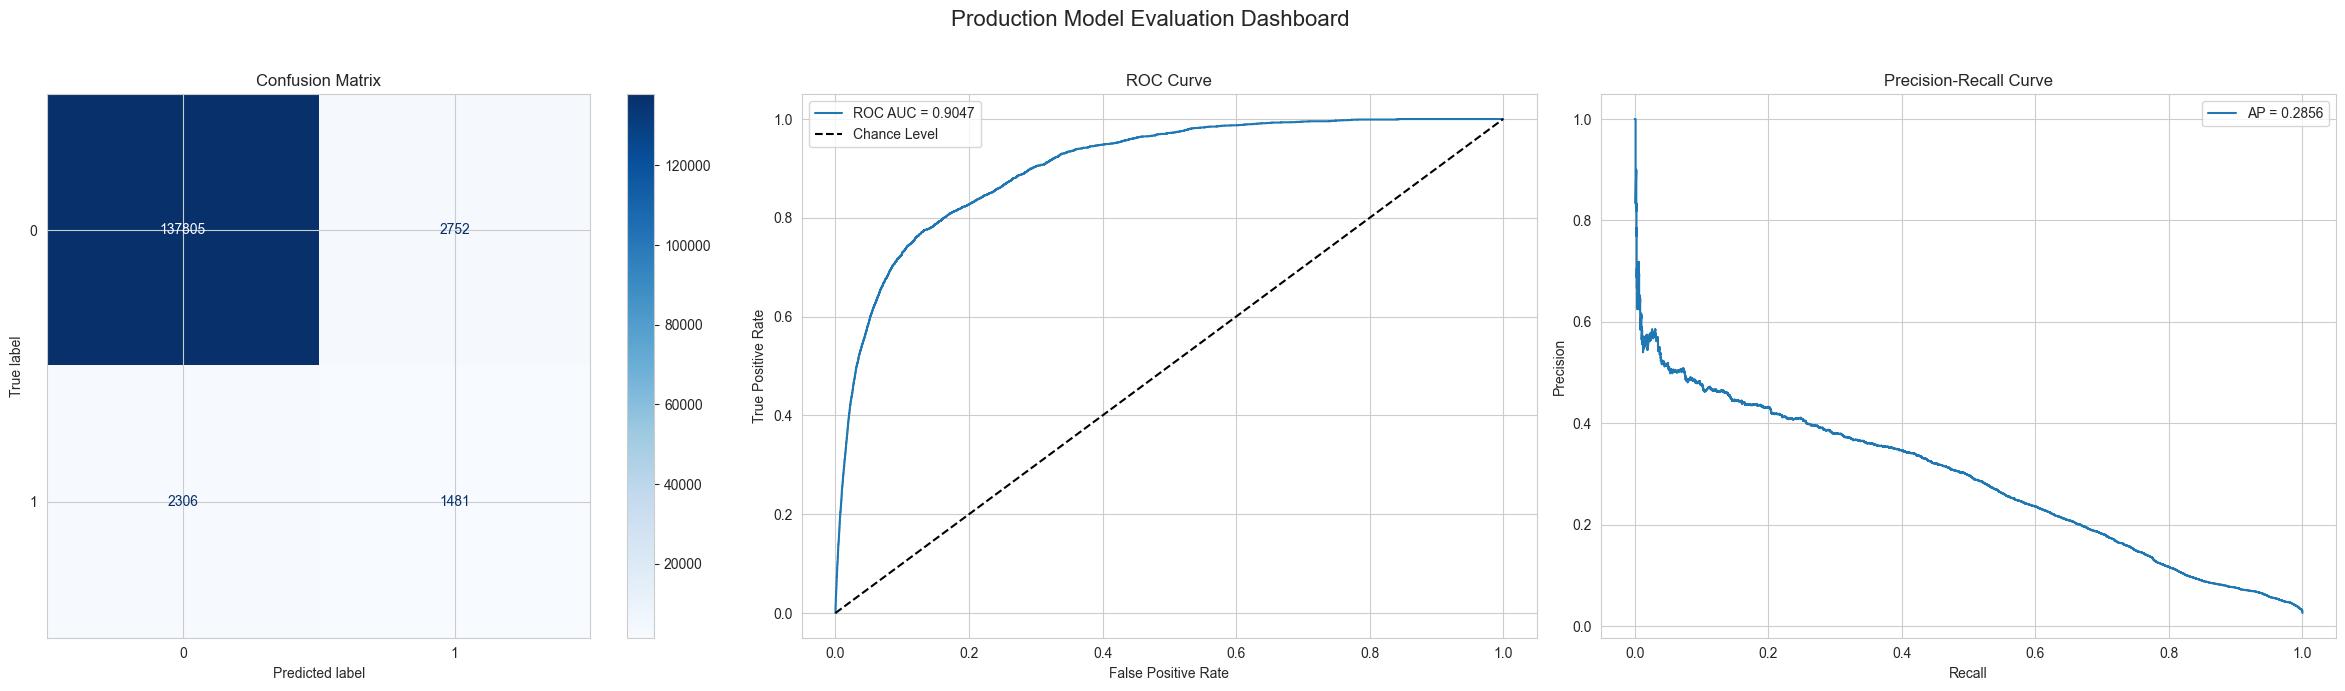

In [6]:
def train_and_evaluate_production_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    preprocessor: Pipeline,
    feature_selector: BaseEstimator,
    classifier_class: BaseEstimator,
    best_params: Dict[str, Any],
    optimal_threshold: float
) -> Tuple[ImbPipeline, Dict[str, Any], plt.Figure]:
    """Builds, trains, and evaluates the final production model."""
    print("=== Production Model Training and Evaluation ===")

    # 1. Assemble the full production pipeline
    print("Assembling the production pipeline...")
    # Define base parameters for Logistic Regression
    if classifier_class.__name__ == 'LogisticRegression':
        base_params = {
            'random_state': 42,
            'max_iter': 1000,
            'class_weight': 'balanced',
            'n_jobs': -1,
            'solver': 'liblinear'
        }
    else:
        base_params = {'random_state': 42}

    # Clean parameter keys from the tuning phase and update base parameters
    tuned_params = {k.split('__', 1)[1]: v for k, v in best_params.items()}
    final_params = {**base_params, **tuned_params}
    
    print(f"Final classifier parameters: {final_params}")
    classifier = classifier_class(**final_params)
    
    production_model = ImbPipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('classifier', classifier)
    ])

    # 2. Train the production model on the final training window
    print(f"Training the final model on {X_train.shape[0]} samples...")
    start_time = time.time()
    production_model.fit(X_train, y_train)
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

    # 3. Evaluate on the test set using the optimal threshold
    print("\nEvaluating the model on the test set...")
    y_pred_proba = production_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    # 4. Generate a comprehensive evaluation report
    evaluation_report = {
        "f1_score": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred_proba),
        "mcc": matthews_corrcoef(y_test, y_pred),
        "log_loss": log_loss(y_test, y_pred_proba),
        "optimal_threshold": optimal_threshold,
        "training_duration_seconds": end_time - start_time
    }
    print("Evaluation Metrics:")
    for metric, value in evaluation_report.items():
        print(f"  {metric}: {value:.4f}")

    # 5. Create a visual evaluation dashboard
    print("\nGenerating evaluation dashboard...")
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle('Production Model Evaluation Dashboard', fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axes[0], cmap='Blues')
    axes[0].set_title('Confusion Matrix')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f"ROC AUC = {evaluation_report['roc_auc']:.4f}")
    axes[1].plot([0, 1], [0, 1], 'k--', label='Chance Level')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)
    axes[2].plot(recall, precision, label=f'AP = {ap:.4f}')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return production_model, evaluation_report, fig

# Execute Model Training and Evaluation
model_class_map = {'LogisticRegression': LogisticRegression}
classifier_class = model_class_map.get(best_model_name)

if classifier_class:
    production_model, evaluation_report, evaluation_dashboard_fig = train_and_evaluate_production_model(
        X_train=X_train,
        y_train=y_train_engineered,
        X_test=X_test,
        y_test=y_test_engineered,
        preprocessor=preprocessor,
        feature_selector=feature_selector,
        classifier_class=classifier_class,
        best_params=best_params,
        optimal_threshold=optimal_threshold
    )
else:
    print(f"Model class for '{best_model_name}' not found. Skipping training.")

# 4. Diagnostic and Interpretability Analysis

**Goal:** Perform an in-depth analysis of the trained model to understand its behavior, limitations, and decision-making process.

**Steps:**
1.  **Learning Curves:** Analyze model performance as a function of training set size. This helps diagnose high variance (overfitting) or high bias (underfitting) and assess whether more data would be beneficial. A `TimeSeriesSplit` is used for cross-validation to respect the temporal order of the data.
2.  **SHAP Analysis:** Use SHAP (SHapley Additive exPlanations) to explain the model's predictions. This reveals the "why" behind its decisions by quantifying the impact of each feature.


=== Diagnostic and Interpretability Analysis ===
Generating learning curves...
Total samples for learning curve: 307222
Dynamically calculated sizes for SlidingWindowSplit: train_size=153611, test_size=30722, n_splits=5


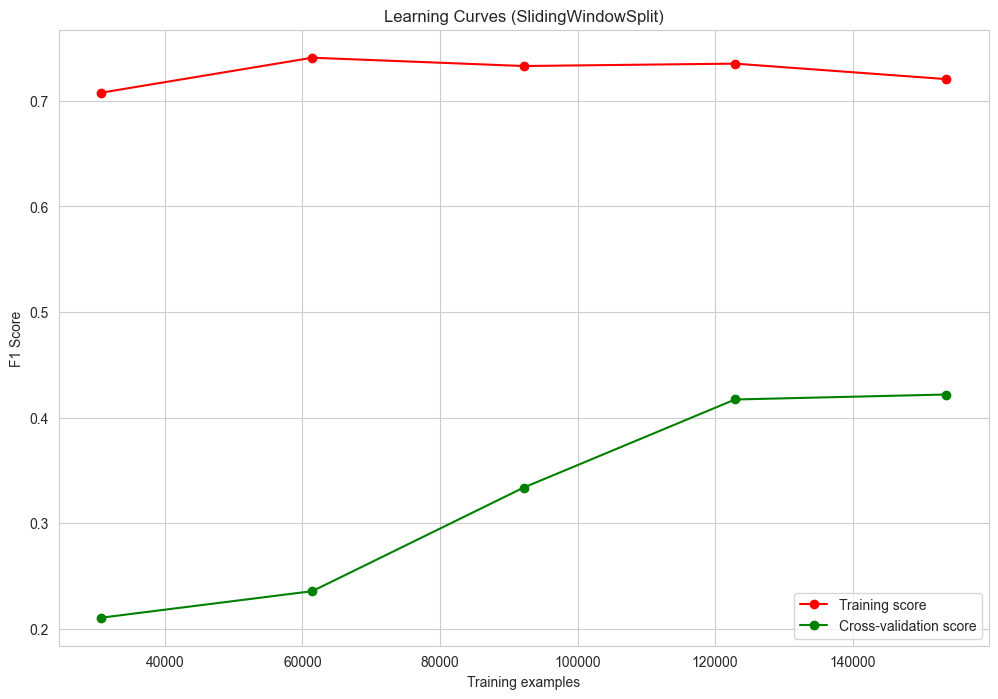


Performing SHAP analysis...
Generating SHAP feature importance plot...


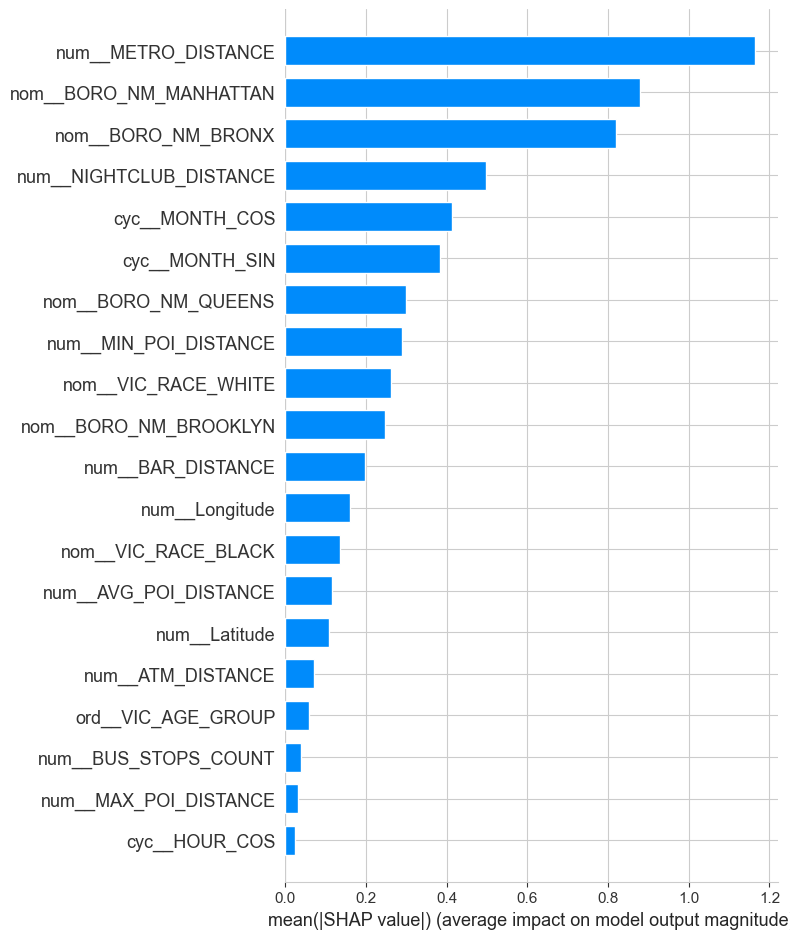

Generating SHAP summary (beeswarm) plot...


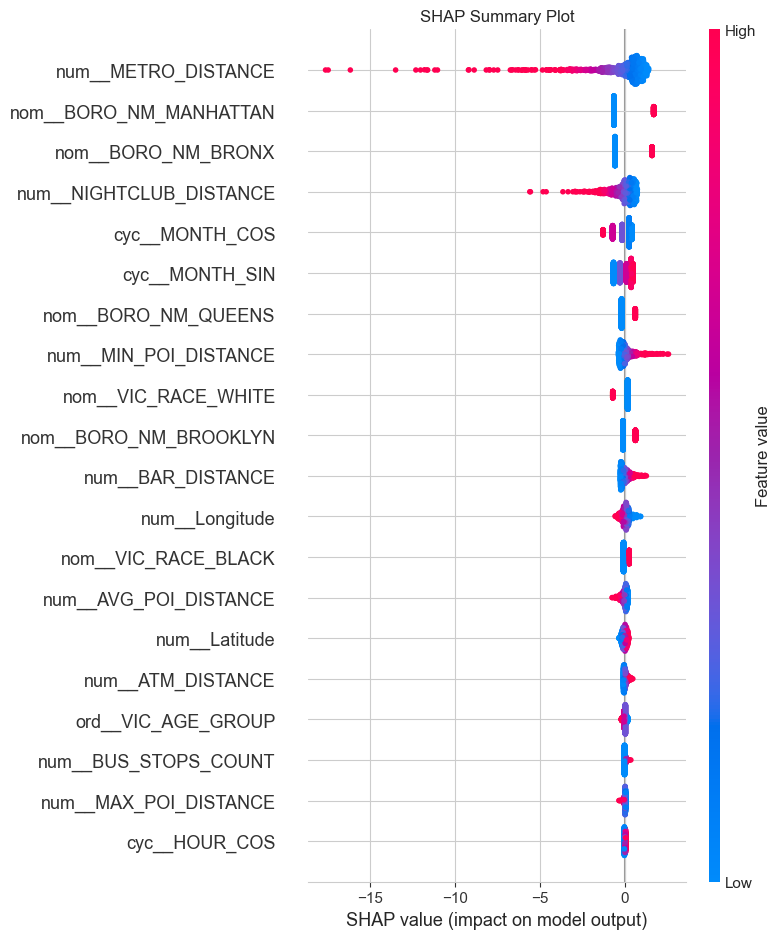

In [7]:
def perform_diagnostic_and_shap_analysis(
    production_model: ImbPipeline,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series
) -> Tuple[Optional[plt.Figure], Optional[plt.Figure], Optional[plt.Figure]]:
    """Performs diagnostic (learning curves) and interpretability (SHAP) analysis."""
    print("\n=== Diagnostic and Interpretability Analysis ===")

    # 1. Diagnostic Analysis: Learning Curves
    print("Generating learning curves...")
    learning_curve_fig = None
    try:
        # Combine train and test for a more robust learning curve over all available data
        X_combined = pd.concat([X_train, X_test]).sort_index() # Sort to maintain time order
        y_combined = pd.concat([y_train, y_test]).sort_index()

        n_samples_total = len(X_combined)
        n_splits_cv = 5 # Or load from config if preferred

        # Dynamically calculate train and test sizes for the learning curve CV
        # Ensure the total size does not exceed the number of available samples.
        # The test set for each split will be a fraction of the data left after the initial train window.
        initial_train_fraction = 0.5 # Use 50% for the first training window
        
        # Calculate sizes based on the actual combined data
        lc_train_size = int(n_samples_total * initial_train_fraction)
        remaining_samples = n_samples_total - lc_train_size
        lc_test_size = remaining_samples // n_splits_cv

        print(f"Total samples for learning curve: {n_samples_total}")
        print(f"Dynamically calculated sizes for SlidingWindowSplit: train_size={lc_train_size}, test_size={lc_test_size}, n_splits={n_splits_cv}")

        if lc_train_size <= 0 or lc_test_size <= 0:
            raise ValueError("Calculated train or test size is zero. Not enough data for learning curves.")

        sliding_cv = SlidingWindowSplit(
            n_splits=n_splits_cv,
            train_size=lc_train_size,
            test_size=lc_test_size
        )

        train_sizes, train_scores, test_scores = learning_curve(
            estimator=clone(production_model),
            X=X_combined,
            y=y_combined,
            cv=sliding_cv,
            scoring='f1',
            n_jobs=-1,
            train_sizes=np.linspace(0.2, 1.0, n_splits_cv)
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        learning_curve_fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax.set_title("Learning Curves (SlidingWindowSplit)")
        ax.set_xlabel("Training examples")
        ax.set_ylabel("F1 Score")
        ax.legend(loc="best")
        ax.grid(True)
        plt.show()
    except Exception as e:
        print(f"Could not generate learning curves: {e}")

    # 2. Interpretability Analysis with SHAP
    print("\nPerforming SHAP analysis...")
    shap_importance_fig, shap_summary_fig = None, None
    try:
        # Extract fitted steps from the production pipeline
        preprocessor_step = production_model.named_steps['preprocessor']
        selector_step = production_model.named_steps['feature_selector']
        classifier_step = production_model.named_steps['classifier']

        # To understand what the model has learned, we explain its predictions on a sample of the training data.
        # This is a standard practice and avoids any form of data leakage.
        X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        
        # Apply the same transformations as in the pipeline
        X_train_transformed = preprocessor_step.transform(X_train_sample)
        X_train_selected = selector_step.transform(X_train_transformed)

        # Get feature names after all transformations for clear plot labels
        transformed_names = preprocessor_step.get_feature_names_out()
        selected_indices = selector_step.get_support(indices=True)
        selected_feature_names = [transformed_names[i] for i in selected_indices]
        
        X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)

        # Initialize SHAP explainer and calculate SHAP values
        explainer = shap.LinearExplainer(classifier_step, X_train_selected_df)
        shap_values = explainer.shap_values(X_train_selected_df)

        # SHAP Feature Importance Plot
        print("Generating SHAP feature importance plot...")
        shap_importance_fig, ax_imp = plt.subplots()
        shap.summary_plot(shap_values, X_train_selected_df, plot_type="bar", show=False)
        plt.tight_layout()
        plt.show()

        # SHAP Summary (Beeswarm) Plot
        print("Generating SHAP summary (beeswarm) plot...")
        shap_summary_fig, ax_sum = plt.subplots()
        shap.summary_plot(shap_values, X_train_selected_df, show=False)
        plt.title("SHAP Summary Plot")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not perform SHAP analysis: {e}")

    return learning_curve_fig, shap_importance_fig, shap_summary_fig

# Execute Phase 4
if 'production_model' in locals():
    learning_curve_fig, shap_importance_fig, shap_summary_fig = perform_diagnostic_and_shap_analysis(
        production_model=production_model,
        X_train=X_train,
        y_train=y_train_engineered,
        X_test=X_test,
        y_test=y_test_engineered
    )
else:
    print("Skipping Phase 4 because the production model was not trained.")

# 5. Final Saving of Production Artifacts

**Goal:** Save all necessary elements for reproducibility, documentation, and deployment in a structured manner.

**Artifacts Saved:**
1.  **Production Model (`..._production_model.joblib`):** The complete, trained pipeline object. This is the primary deployment artifact.
2.  **Evaluation Report (`..._evaluation_report.json`):** A JSON file containing all test set performance metrics.
3.  **Evaluation Dashboard (`..._evaluation_dashboard.png`):** A composite image of the confusion matrix, ROC curve, and Precision-Recall curve.
4.  **Diagnostic & SHAP Plots (`..._learning_curve.png`, `..._shap_*.png`):** Visualizations from the diagnostic and interpretability analysis.

In [8]:
def save_production_artifacts(
    final_dir: str,
    model_name: str,
    production_model: ImbPipeline,
    evaluation_report: Dict[str, Any],
    evaluation_dashboard_fig: plt.Figure,
    learning_curve_fig: Optional[plt.Figure],
    shap_importance_fig: Optional[plt.Figure],
    shap_summary_fig: Optional[plt.Figure]
):
    """Saves all final production artifacts to the specified directory."""
    print("\n=== Saving Final Production Artifacts ===")
    
    # 1. Production Model
    model_path = os.path.join(final_dir, f"{model_name}_production_model.joblib")
    joblib.dump(production_model, model_path)
    print(f"Saved production model to: {model_path}")

    # 2. Evaluation Report
    report_path = os.path.join(final_dir, f"{model_name}_evaluation_report.json")
    with open(report_path, 'w') as f:
        json.dump(evaluation_report, f, indent=4)
    print(f"Saved evaluation report to: {report_path}")

    # 3. Evaluation Dashboard
    dashboard_path = os.path.join(final_dir, f"{model_name}_evaluation_dashboard.png")
    evaluation_dashboard_fig.savefig(dashboard_path, bbox_inches='tight')
    print(f"Saved evaluation dashboard to: {dashboard_path}")

    # 4. Diagnostic Reports
    if learning_curve_fig:
        lc_path = os.path.join(final_dir, f"{model_name}_learning_curve.png")
        learning_curve_fig.savefig(lc_path, bbox_inches='tight')
        print(f"Saved learning curve plot to: {lc_path}")

    # 5. SHAP Analysis Plots
    if shap_importance_fig:
        shap_imp_path = os.path.join(final_dir, f"{model_name}_shap_feature_importance.png")
        shap_importance_fig.savefig(shap_imp_path, bbox_inches='tight')
        print(f"Saved SHAP feature importance plot to: {shap_imp_path}")

    if shap_summary_fig:
        shap_sum_path = os.path.join(final_dir, f"{model_name}_shap_summary.png")
        shap_summary_fig.savefig(shap_sum_path, bbox_inches='tight')
        print(f"Saved SHAP summary plot to: {shap_sum_path}")
        
    print("\nAll production artifacts have been saved successfully.")

# Execute Phase 5
if 'production_model' in locals():
    save_production_artifacts(
        final_dir=final_dir,
        model_name=best_model_name,
        production_model=production_model,
        evaluation_report=evaluation_report,
        evaluation_dashboard_fig=evaluation_dashboard_fig,
        learning_curve_fig=learning_curve_fig,
        shap_importance_fig=shap_importance_fig,
        shap_summary_fig=shap_summary_fig
    )
else:
    print("Skipping Phase 5 because no production model was trained.")


=== Saving Final Production Artifacts ===
Saved production model to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_production_model.joblib
Saved evaluation report to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_evaluation_report.json
Saved evaluation dashboard to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_evaluation_dashboard.png
Saved learning curve plot to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_learning_curve.png
Saved SHAP feature importance plot to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_shap_feature_importance.png
Saved SHAP summary plot to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_shap_summary.png

All productio